In [1]:
import numpy as np
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import multiprocessing
import os
import itertools
import joblib
import time
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy import ndimage

/work/08550/qz3485/miniconda3/envs/data_science/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Load the data. The time interval between each data is changed to 2 hours. 

The first dimension of the data is each satellite. 

The second dimension of the data is the time series over the month of Feburary. 

The third dimension of the data contains the physical quantities at each time point. 

- 0: time
- 1, 2, 3: 3D position 
- 4, 5, 6: 3D velocity
- 7, 8, 9: 3D angular momentum

In [2]:
starlink_data = np.load("starlink_data.npy")
print(starlink_data.shape)

# Slice to get a time interval of 2 hours
satellite_time = starlink_data[:, ::24, 0]
angular_momentum = starlink_data[:, ::24, 7:]
position = starlink_data[:, ::24, 1:4]

radius = np.linalg.norm(position, ord=2, axis=2)
angular_momentum_mag = np.linalg.norm(angular_momentum, ord=2, axis=2)

(1984, 8018, 10)


Smooth the data using a moving average.

In [3]:
for i in range(position.shape[0]):
    # Find the first index that has a value of nan. 
    if np.isnan(position[i, -1, 0]):
        nan_index = np.argwhere(np.isnan(position[i, :, 0]))[0][0]
    else:
        nan_index = position.shape[1]

    # The moving average is done on the data without the nan values. 
    angular_momentum[i, :nan_index, :] = ndimage.uniform_filter1d(angular_momentum[i, :nan_index, :], size=50, axis=0)
    radius[i, :nan_index] = ndimage.uniform_filter1d(radius[i, :nan_index], size=50, axis=0)
    angular_momentum_mag[i, :nan_index] = ndimage.uniform_filter1d(angular_momentum_mag[i, :nan_index], size=50, axis=0)

Center the data to 0 rowise by subtracting the mean. 

In [4]:
normed_angular_momentum = angular_momentum - np.nanmean(angular_momentum, axis=1, keepdims=True)
normed_radius = (radius - np.nanmean(radius, axis=1, keepdims=True))[:, :, None]
normed_angular_momentum_mag = (angular_momentum_mag - np.nanmean(angular_momentum_mag, axis=1, keepdims=True))[:, :, None]

print(satellite_time.shape)
print(normed_angular_momentum.shape)
print(normed_angular_momentum_mag.shape)
print(normed_radius.shape)

(1984, 335)
(1984, 335, 3)
(1984, 335, 1)
(1984, 335, 1)


Plot the 3D angular momentum at the first time point. 

In [27]:
def plot_3d(time_point: int, 
            data: np.ndarray, 
            ax: plt.Axes, 
            cluster_labels: np.ndarray = None, 
            num_cluster: int = None):
    '''
    Plot 3D time-series data at a specific time point
    The data points can be colored with cluster labels
    '''

    plt.cla()
    if cluster_labels is None:
        ax.scatter(data[:, time_point, 0], 
            data[:, time_point, 1], 
            data[:, time_point, 2], 
            s = 40)
    else:
        for i in range(num_cluster):
            ax.scatter(data[cluster_labels == i][:, time_point, 0], 
                        data[cluster_labels == i][:, time_point, 1], 
                        data[cluster_labels == i][:, time_point, 2], 
                        s = 40, 
                        label = "Cluster " + str(i))
            ax.legend()

    ax.set_xlabel('h_x')
    ax.set_ylabel('h_y')
    ax.set_zlabel('h_z')
    ax.set_xlim([-50000, 50000])
    ax.set_ylim([-50000, 50000])
    ax.set_zlim([30500, 32000])

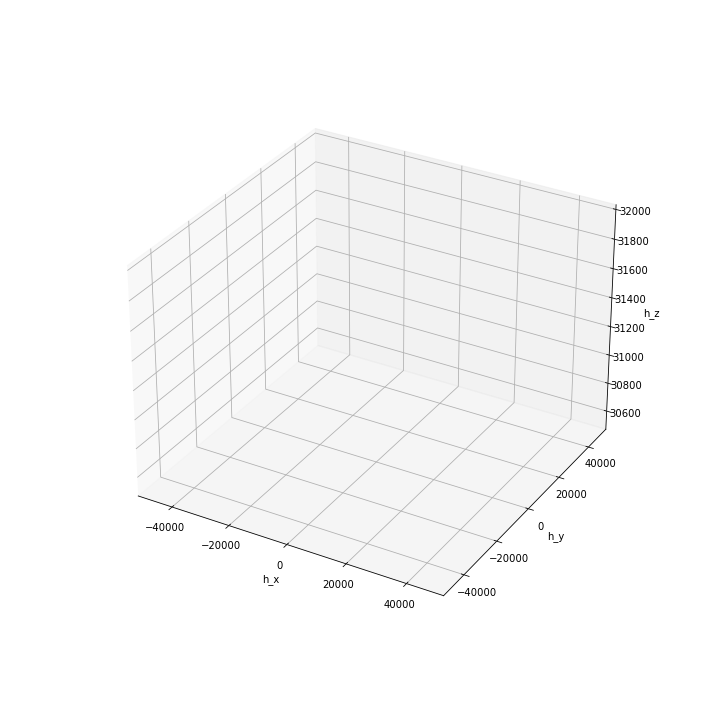

In [29]:
%matplotlib widget

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
plot_3d(0, normed_angular_momentum, ax)
plt.ion()
plt.show()

Plot a couple time-series data for angular momentum. 

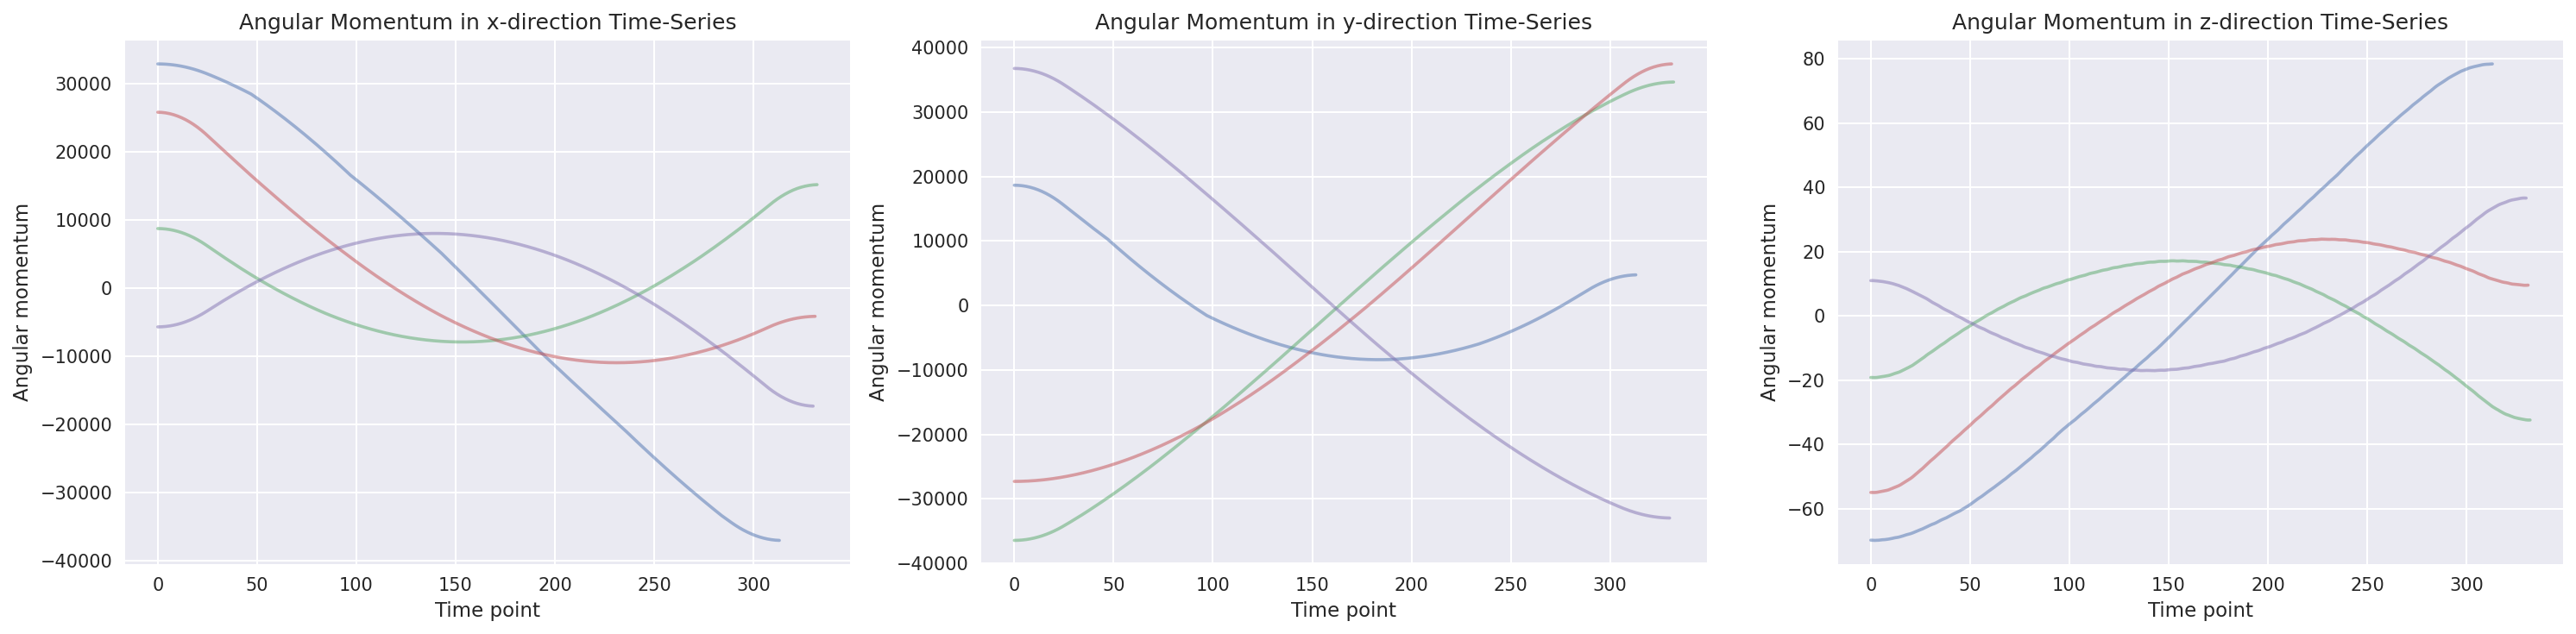

In [31]:
%matplotlib inline

plt.figure(figsize=(20, 5), dpi=150)
with plt.style.context("seaborn"):
    for i in range(3):
        plt.subplot(1, 3, i+1)
        for ts in normed_angular_momentum[::500, :, :]:
            plt.plot(ts[:, i], alpha=0.5)

        if i == 0:
            plt.title("Angular Momentum in x-direction Time-Series")
        elif i == 1:
            plt.title("Angular Momentum in y-direction Time-Series")
        elif i == 2:
            plt.title("Angular Momentum in z-direction Time-Series")

        plt.xlabel("Time point")
        plt.ylabel("Angular momentum")

plt.tight_layout()
plt.show()

Plot a couple time-series data for radius. 

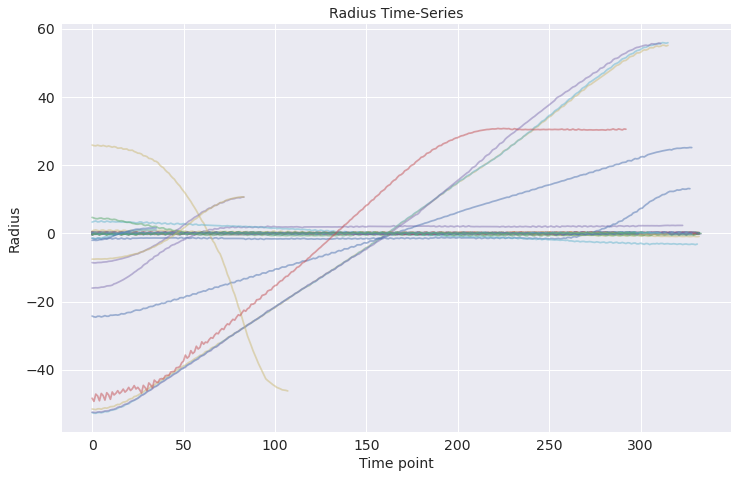

In [26]:
%matplotlib inline

plt.figure(figsize=(12, 7.5))
with plt.style.context("seaborn"):
    for ts in normed_radius[::30, :]:
        plt.plot(ts, alpha=0.5)
plt.title("Radius Time-Series", fontsize=14)
plt.xlabel("Time point", fontsize=14)
plt.ylabel("Radius", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Plot a couple time-series data for magniude of angular momentum. 

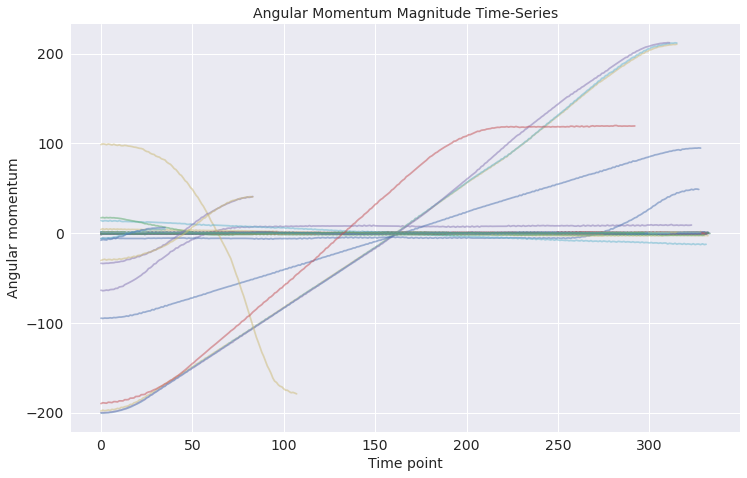

In [17]:
%matplotlib inline

plt.figure(figsize=(12, 7.5))
with plt.style.context("seaborn"):
    for ts in normed_angular_momentum_mag[::30, :]:
        plt.plot(ts, alpha=0.5)
plt.title("Angular Momentum Magnitude Time-Series", fontsize=14)
plt.xlabel("Time point", fontsize=14)
plt.ylabel("Angular momentum", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [8]:
def ts_kmeans_func(data: np.ndarray, num_cluster: int) -> TimeSeriesKMeans:
    ts_kmeans = TimeSeriesKMeans(n_clusters=num_cluster, 
                                metric="dtw", 
                                random_state=0, 
                                n_jobs=os.cpu_count()//num_cluster).fit(data)
                                
    print("Num cluster:", num_cluster, "Sum of squares:", ts_kmeans.inertia_)
    return ts_kmeans

def silhouette_score_func(ts_kmeans_model: TimeSeriesKMeans, data: np.ndarray):
    cluster_labels = ts_kmeans_model.labels_
    num_cluster = len(np.unique(cluster_labels))

    score = silhouette_score(data, 
                            cluster_labels, 
                            metric="dtw", 
                            n_jobs=-1, 
                            random_state=0)

    print("Num cluster:", num_cluster, "Silhouette Score:", score)
    return score

def ts_kmeans_elbow(data: np.ndarray, num_cluster: int):
    '''
    Calculates the sum of squares and silhouette score for different number of clusters using time-series K-means.
    The elbow method is used to select an optimal number of cluster for sum of squares.
    Parallized model fitting over each number of cluster. 
    '''
    cluster_list = range(2, num_cluster+1)
    multiprocessing_data = zip(itertools.repeat(data), cluster_list)
    
    with multiprocessing.Pool(processes=len(cluster_list)) as pool:
        ts_kmeans_list = pool.starmap(ts_kmeans_func, multiprocessing_data)
        silhouette_score_list = pool.starmap(silhouette_score_func, zip(ts_kmeans_list, itertools.repeat(data)))

    sum_squares = [val.inertia_ for val in ts_kmeans_list]

    plt.figure(figsize=(12, 7.5))
    with plt.style.context("seaborn"):
        plt.plot(cluster_list, sum_squares)
    plt.ylabel('Sum of Squares', fontsize = 14)
    plt.xlabel('Number of clusters', fontsize = 14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    plt.figure(figsize=(12, 7.5))
    with plt.style.context("seaborn"):
        plt.plot(cluster_list, silhouette_score_list)
    plt.ylabel('Silhouette Score', fontsize = 14)
    plt.xlabel('Number of clusters', fontsize = 14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    return ts_kmeans_list

In [5]:
def load_ts_kmeans_model(ts_kmeans_model: TimeSeriesKMeans, data: np.ndarray): 
    '''
    Get the cluster information from a time-series kmeans model
    '''
    cluster_labels = ts_kmeans_model.labels_
    
    optimal_cluster, counts = np.unique(cluster_labels, return_counts=True)
    optimal_cluster_num = len(optimal_cluster)
    for i, val in enumerate(counts):
        print("Size of Cluster " + str(i), val)

    # cluster_centers = np.zeros(ts_kmeans_model.cluster_centers_.shape)
    # for i in range(optimal_cluster_num):
    #     cluster_centers[i] = np.nanmean(data[cluster_labels==i], axis=0)

    cluster_centers = ts_kmeans_model.cluster_centers_

    return optimal_cluster_num, cluster_labels, cluster_centers

In [6]:
def ts_cluster_plot(data: np.ndarray, 
            num_cluster: int, 
            cluster_labels: np.ndarray, 
            cluster_centers: np.ndarray, 
            dimension: int):
    '''
    Plot the time-series data and the cluster center in each cluster. 
    '''
    for i in range(num_cluster):
        # Plot all the clusters in a subplot if there is only 1 quantity at each time point
        if dimension == 1:
            plt.subplot(num_cluster//3+1, 3, i+1)
            
            # Plot the same number of time-series for different-sized clusters
            data_cluster_i = data[cluster_labels == i]
            for ts in data_cluster_i[::data_cluster_i.shape[0]//20, :]:
                plt.plot(ts, "k-", linewidth=0.1)

            plt.plot(cluster_centers[i, :], "r-")

            plt.title("Cluster " + str(i+1))
            plt.xticks(fontsize=8)
            plt.yticks(fontsize=8)
        # If there are multiple quantities at a point time, 
        # plot 1 cluster on each row of subplot with each quantity in a column
        else:
            for j in range(dimension):
                plt.subplot(num_cluster, dimension, i*dimension+j+1)
                
                data_cluster_i = data[cluster_labels == i]
                for ts in data[cluster_labels == i][::data_cluster_i.shape[0]//20, :, j]:
                    plt.plot(ts, "k-", linewidth=0.1)

                plt.plot(cluster_centers[i, :, j], "r-")

                plt.xticks(fontsize=8)
                plt.yticks(fontsize=8)

                if i == 0 and j == 0:
                    plt.title("Angular Momentum in x-direction", fontsize=8)
                elif i == 0 and j == 1:
                    plt.title("Angular Momentum in y-direction", fontsize=8)
                elif i == 0 and j == 2:
                    plt.title("Angular Momentum in z-direction", fontsize=8)
            plt.figtext(0.5, 1-(i*(1/num_cluster+0.01)), "Cluster " + str(i+1))

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    plt.show()

Apply time-series k-means clustering to all 3 directions of angular momentum. 

Num cluster: 2 Sum of squares: 24266041053.0482
Num cluster: 5 Sum of squares: 7243093508.9038515
Num cluster: 6 Sum of squares: 5286738850.549206
Num cluster: 3 Sum of squares: 12873173354.072405
Num cluster: 7 Sum of squares: 4420731086.683889
Num cluster: 4 Sum of squares: 8737337550.53343
Num cluster: 8 Sum of squares: 3342487879.47933
Num cluster: 9 Sum of squares: 3036154110.722934
Num cluster: 10 Sum of squares: 2432686958.3132114


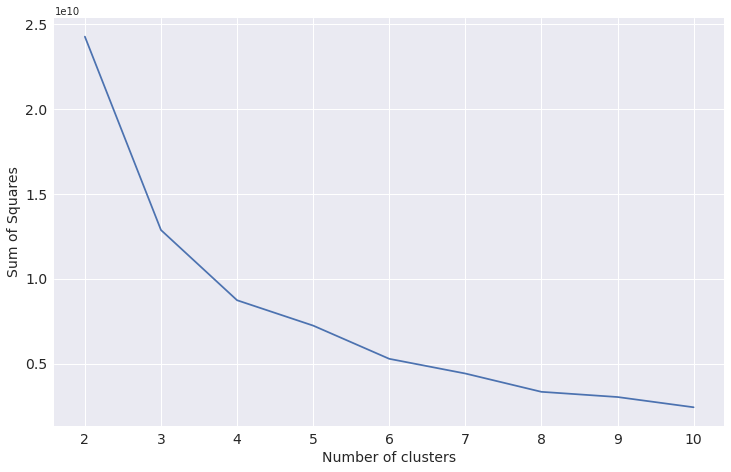

Elapsed time: 1415.8976249694824


In [11]:
%matplotlib inline

start_time = time.time()
ts_kmeans_list = ts_kmeans_elbow(normed_angular_momentum, num_cluster=10)
print("Elapsed time:", time.time()-start_time)

joblib.dump(ts_kmeans_list, 'ts_kmeans_angular_momentum.joblib')

Pick the optimal number of cluster. Save the model. 

In [12]:
optimal_cluster = 5
joblib.dump(ts_kmeans_list[optimal_cluster-2], 'ts_kmeans_angular_momentum.joblib')

['ts_kmeans_angular_momentum.joblib']

Load the model if it already exists.

Size of Cluster 0 398
Size of Cluster 1 528
Size of Cluster 2 510
Size of Cluster 3 418
Size of Cluster 4 130
0.5070315303636949


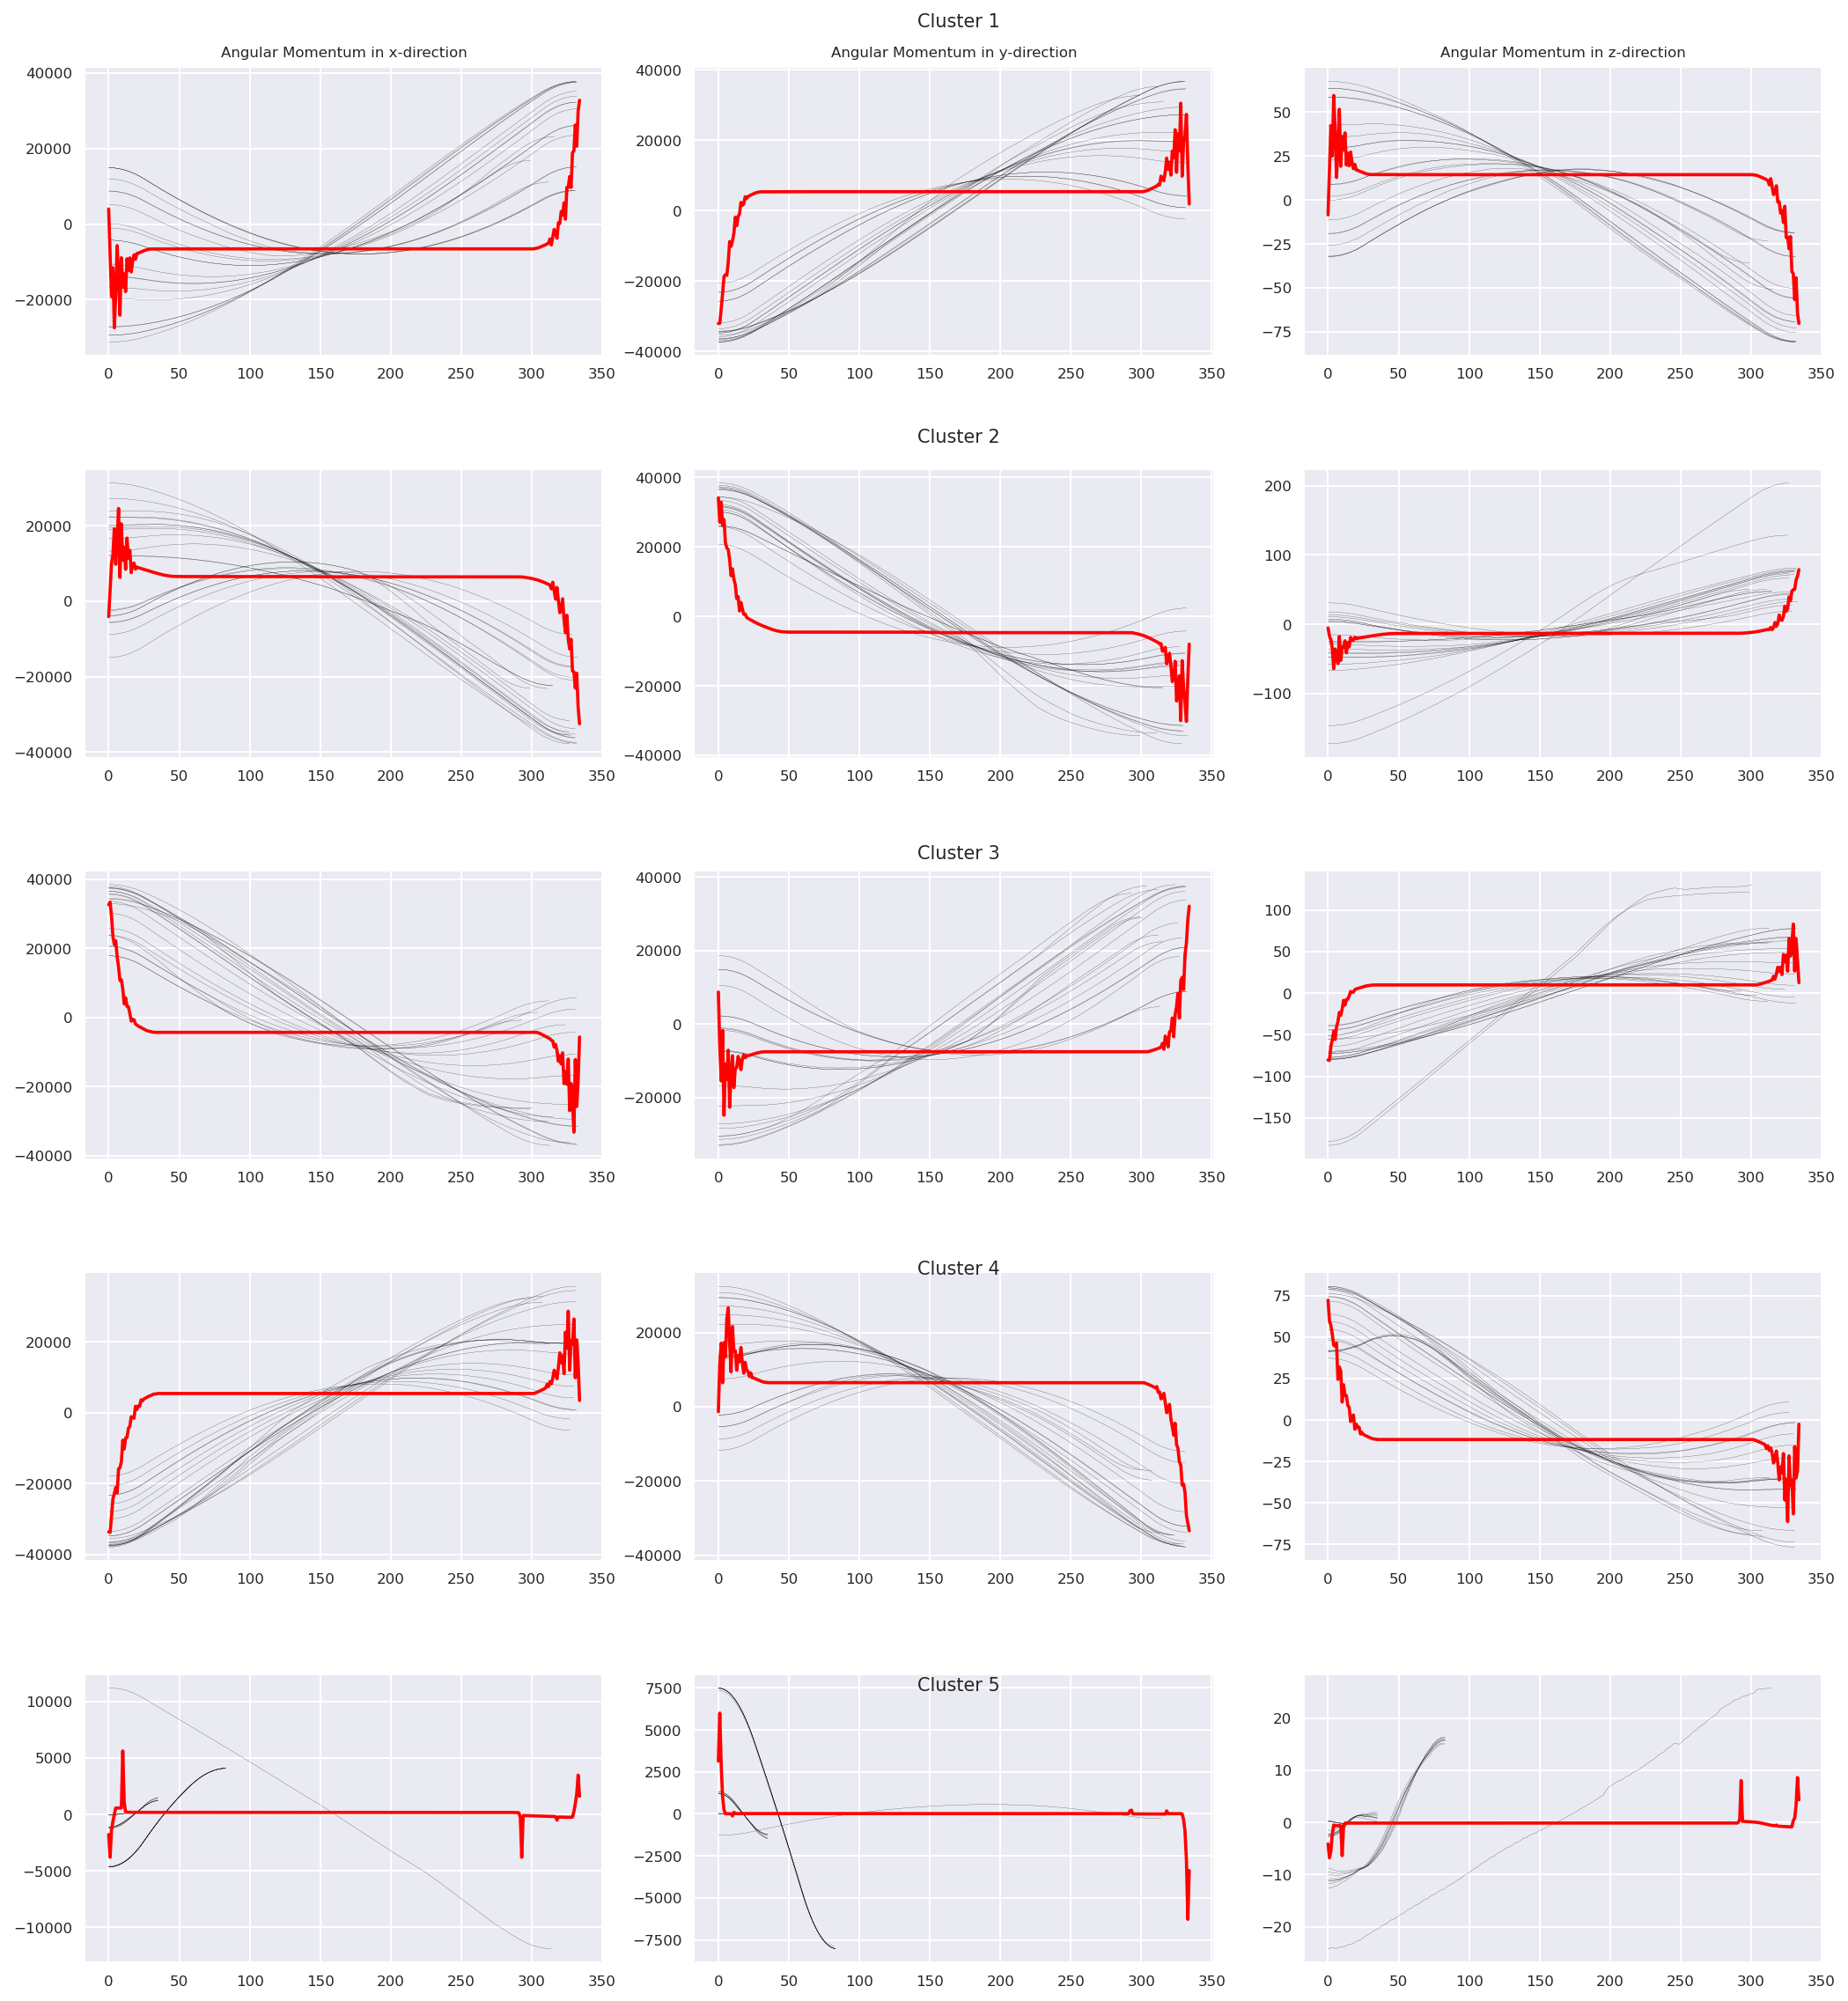

In [7]:
%matplotlib inline

ts_kmeans_angular_momentum = joblib.load('ts_kmeans_angular_momentum.joblib')
optimal_cluster_AM, cluster_labels_AM, cluster_centers_AM = load_ts_kmeans_model(ts_kmeans_angular_momentum, normed_angular_momentum)

plt.figure(figsize=(14, 15), dpi=150)
with plt.style.context("seaborn"):
    ts_cluster_plot(normed_angular_momentum, 
                    optimal_cluster_AM, 
                    cluster_labels_AM, 
                    cluster_centers_AM, 
                    3)

Apply time-series k-means clustering to radius. 

Num cluster: 5 Sum of squares: 204.36930696906046
Num cluster: 4 Sum of squares: 261.9721146495878
Num cluster: 3 Sum of squares: 318.5217875970222
Num cluster: 7 Sum of squares: 73.37263545543472
Num cluster: 8 Sum of squares: 98.78058278310974
Num cluster: 2 Sum of squares: 1096.7200855156618
Num cluster: 9 Sum of squares: 60.84779033910986
Num cluster: 10 Sum of squares: 54.092368626712016
Num cluster: 6 Sum of squares: 94.63985456779841


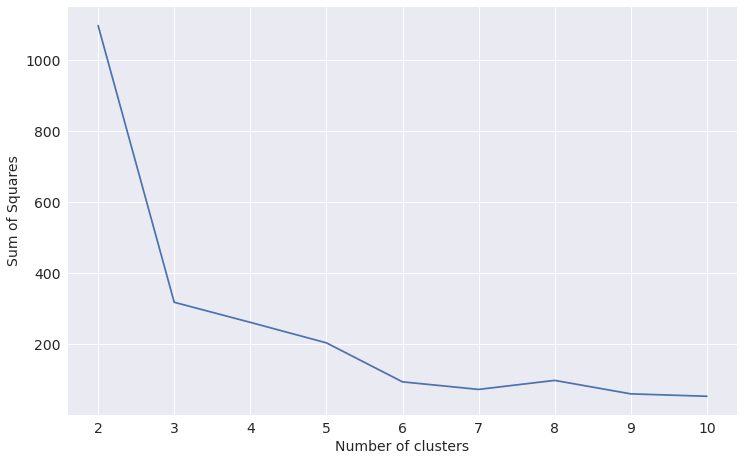

Elapsed time: 1026.4951717853546


In [13]:
%matplotlib inline

start_time = time.time()
ts_kmeans_list = ts_kmeans_elbow(normed_radius, num_cluster=10)
print("Elapsed time:", time.time()-start_time)

In [14]:
optimal_cluster = 3
joblib.dump(ts_kmeans_list[optimal_cluster-2], 'ts_kmeans_radius.joblib')

['ts_kmeans_radius.joblib']

In [8]:
%matplotlib inline

ts_kmeans_radius = joblib.load('ts_kmeans_radius.joblib') 
optimal_cluster_R, cluster_labels_R, cluster_centers_R = load_ts_kmeans_model(ts_kmeans_radius, normed_radius)

plt.figure(figsize=(14, 7), dpi=150)
with plt.style.context("seaborn"):
    ts_cluster_plot(normed_radius, 
                    optimal_cluster_R, 
                    cluster_labels_R, 
                    cluster_centers_R, 
                    1)

Size of Cluster 0 1812
Size of Cluster 1 138
Size of Cluster 2 34


Apply time-series k-means clustering to the magnitude of angular momentum. 

Num cluster: 4 Sum of squares: 14238.328308337943
Num cluster: 3 Sum of squares: 14982.212004746485
Num cluster: 6 Sum of squares: 1289.6085791199664
Num cluster: 5 Sum of squares: 2224.6586542725217
Num cluster: 7 Sum of squares: 1198.628308549027
Num cluster: 8 Sum of squares: 774.5949113438737
Num cluster: 2 Sum of squares: 17087.04493140804
Num cluster: 10 Sum of squares: 515.7636259329563
Num cluster: 9 Sum of squares: 593.0387094417789


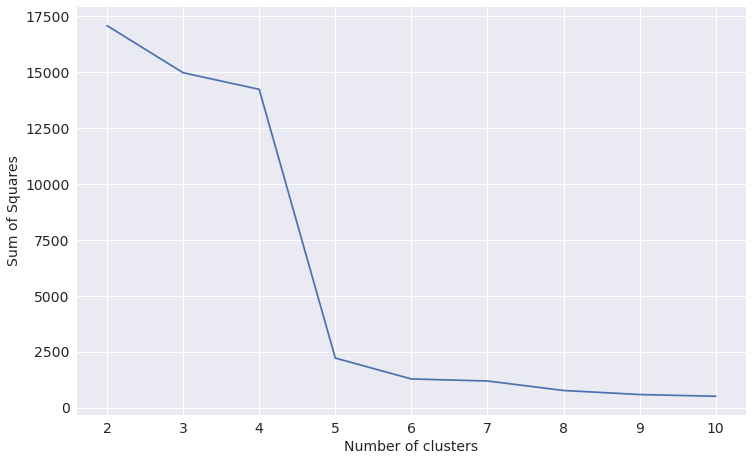

Elapsed time: 1173.6260781288147


In [15]:
%matplotlib inline

start_time = time.time()
ts_kmeans_list = ts_kmeans_elbow(normed_angular_momentum_mag, num_cluster=10)
print("Elapsed time:", time.time()-start_time)

In [16]:
optimal_cluster = 5
joblib.dump(ts_kmeans_list[optimal_cluster-2], 'ts_kmeans_angular_momentum_mag.joblib')

['ts_kmeans_angular_momentum_mag.joblib']

Size of Cluster 0 1705
Size of Cluster 1 112
Size of Cluster 2 82
Size of Cluster 3 56
Size of Cluster 4 29


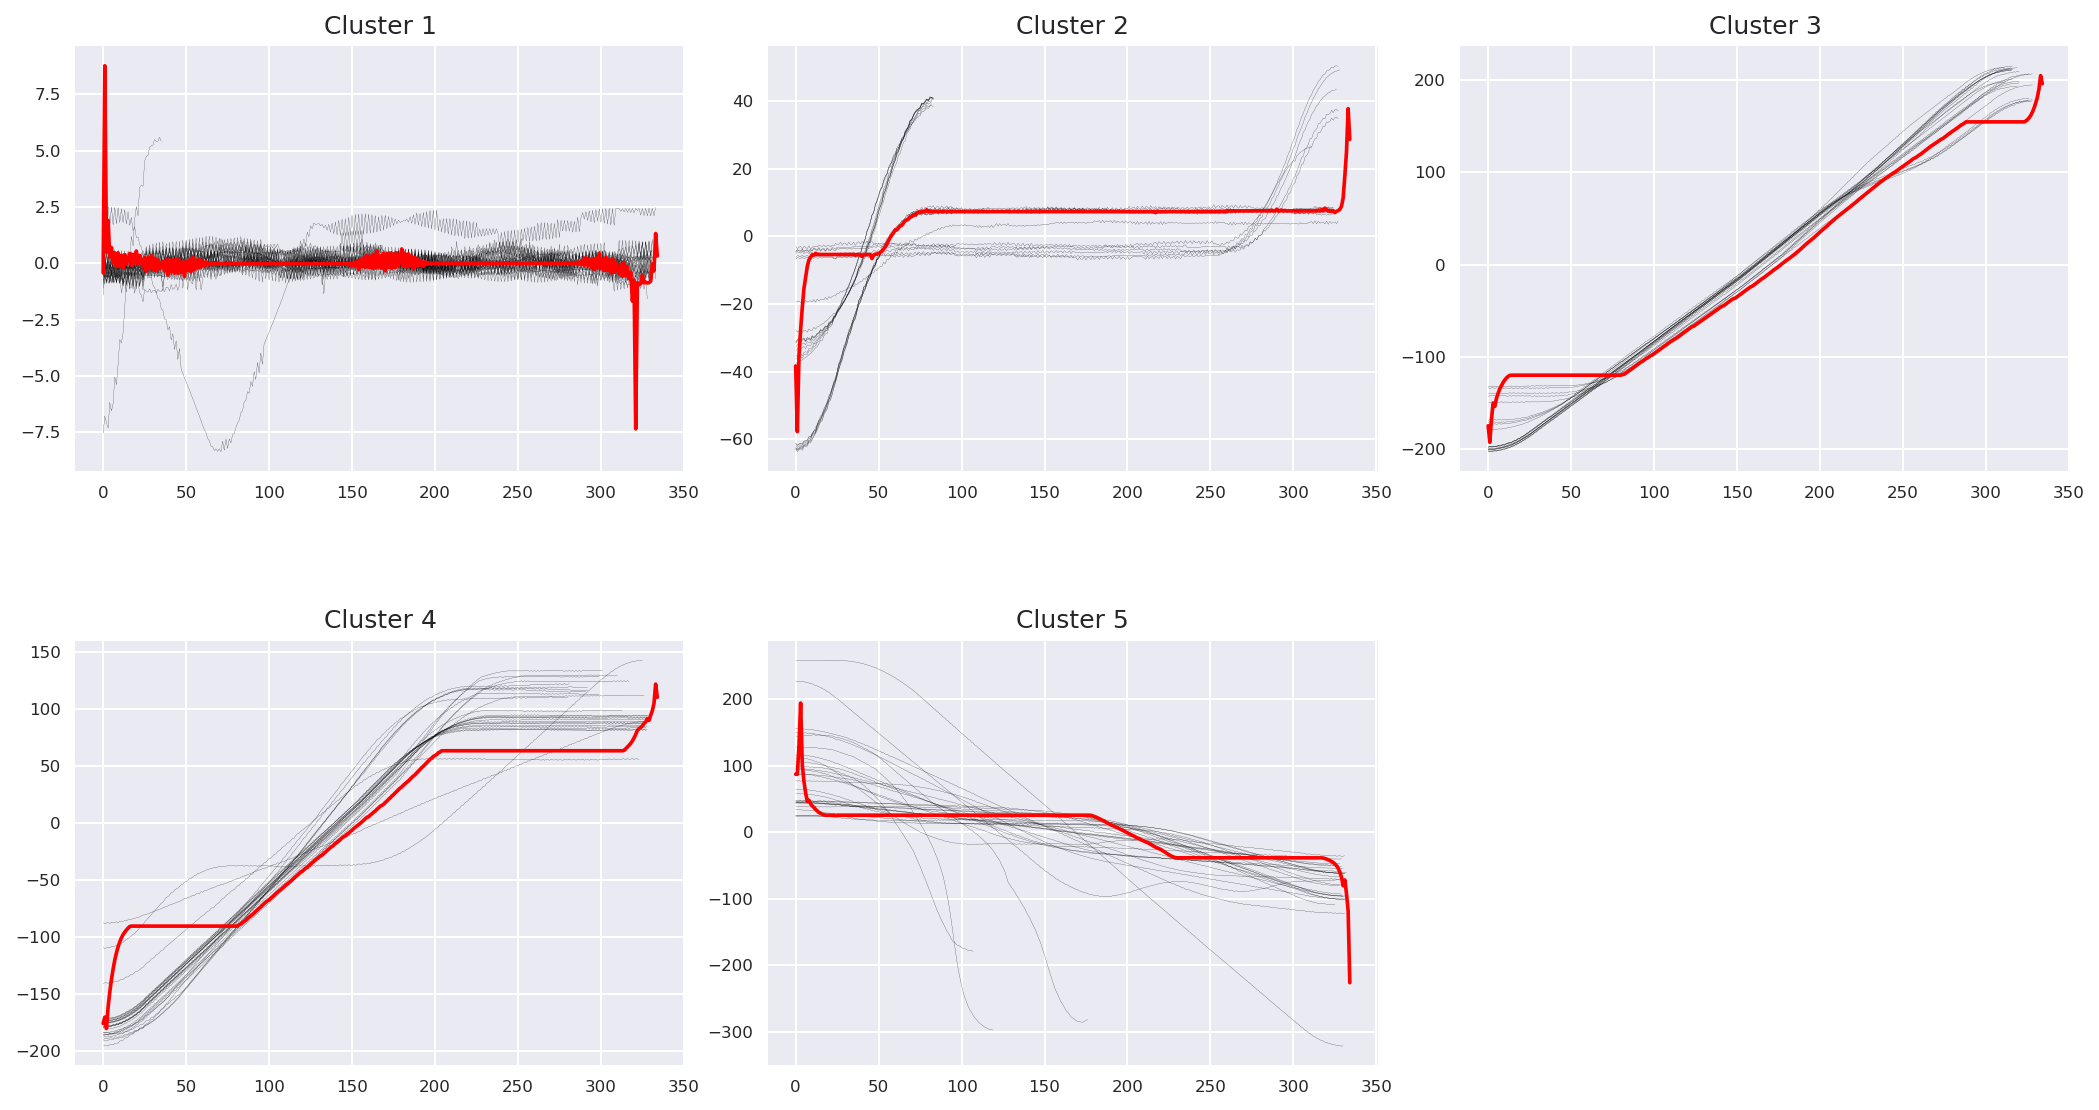

In [49]:
%matplotlib inline

ts_kmeans_angular_momentum_mag = joblib.load('ts_kmeans_angular_momentum_mag.joblib') 
optimal_cluster_AM_mag, cluster_labels_AM_mag, cluster_centers_AM_mag = load_ts_kmeans_model(ts_kmeans_angular_momentum_mag, normed_angular_momentum_mag)

plt.figure(figsize=(14, 7.5), dpi=150)
with plt.style.context("seaborn"):
    ts_cluster_plot(normed_angular_momentum_mag, 
                    optimal_cluster_AM_mag, 
                    cluster_labels_AM_mag, 
                    cluster_centers_AM_mag, 
                    1)

Show the clustering of the data at the 0 time point. 

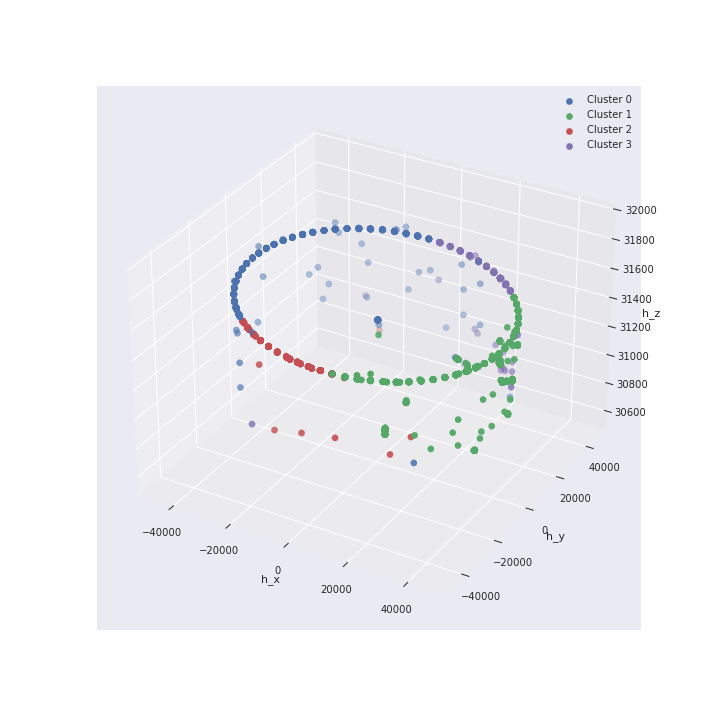

In [51]:
%matplotlib widget

fig2 = plt.figure(figsize = (10, 10))
ax2 = fig2.add_subplot(111, projection='3d')
plot_3d(0, angular_momentum, ax2, cluster_labels_AM, optimal_cluster_AM)
plt.ion()
plt.show()

Create an animation of the evolution of angular momentum with the cluster labelled for each data point. 

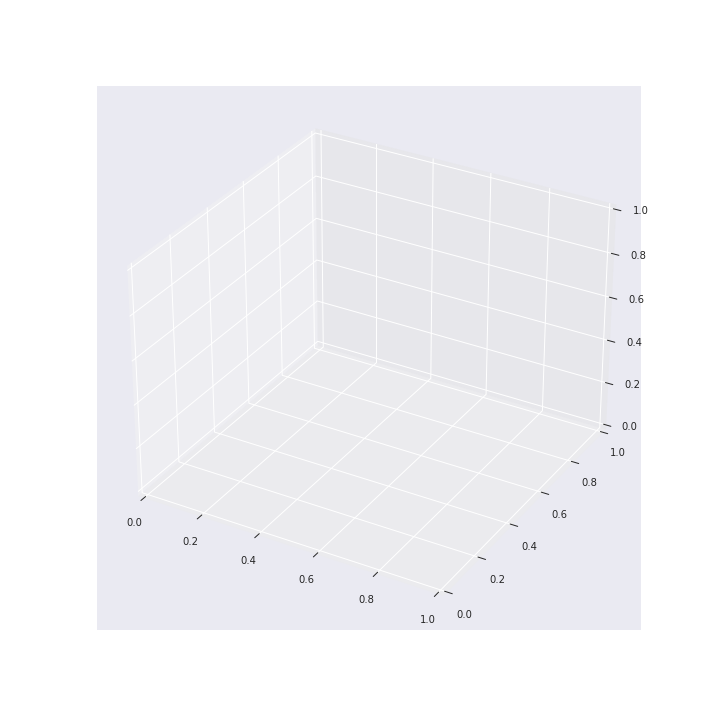

In [68]:
%matplotlib widget

plt.close()

ts_fig = plt.figure(figsize = (10, 10))
ts_ax = ts_fig.add_subplot(111, projection='3d')

anim = animation.FuncAnimation(ts_fig, 
                                plot_3d, 
                                frames=satellite_time.shape[1], 
                                interval=20, 
                                fargs=(angular_momentum, ts_ax, cluster_labels_AM, optimal_cluster_AM),
                                blit=True,
                                repeat_delay=200)

plt.show()